<a href="https://colab.research.google.com/github/Immaczx/SemanticSegmentation/blob/master/NoteBoocks/UnetSegmentationZeaMaysSeeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/Immaczx/SemanticSegmentation.git

Cloning into 'SemanticSegmentation'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 184 (delta 84), reused 144 (delta 44), pack-reused 0
Receiving objects: 100% (184/184), 42.48 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
from SemanticSegmentation import utils
import os
import math as m
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gcpds.image_segmentation.datasets.segmentation import ZeaMaysSeeds
from gcpds.image_segmentation.losses import DiceCoefficient
from gcpds.image_segmentation.metrics import Jaccard, Sensitivity, Specificity
from gcpds.image_segmentation.metrics import DiceCoefficientMetric

In [ ]:
from functools import partial

import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers


DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)

upsample = partial(layers.UpSampling2D, (2,2))

def kernel_initializer(seed):
    return tf.keras.initializers.GlorotUniform(seed=seed)

def unet_baseline(input_shape=(128,128,3), name='UNET', out_channels=1, dropout=0.01, out_ActFunction='sigmoid'):
    # Encoder 
    input = layers.Input(shape=input_shape)

    x =  layers.BatchNormalization(name='Batch00')(input)
  
    x = DefaultConv2D(8,kernel_initializer=kernel_initializer(34),name='Conv10')(x)
    x = layers.BatchNormalization(name='Batch10')(x)
    x = layers.Dropout(dropout)(x)
    x = level_1 = DefaultConv2D(8,kernel_initializer=kernel_initializer(4),name='Conv11')(x)
    x = layers.BatchNormalization(name='Batch11')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultPooling(name='Pool10')(x) # 128x128 -> 64x64

    x = DefaultConv2D(16,kernel_initializer=kernel_initializer(56),name='Conv20')(x)
    x = layers.BatchNormalization(name='Batch20')(x)
    x = layers.Dropout(dropout)(x)
    x = level_2 = DefaultConv2D(16,kernel_initializer=kernel_initializer(32),name='Conv21')(x)
    x = layers.BatchNormalization(name='Batch22')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultPooling(name='Pool20')(x) # 64x64 -> 32x32


    x = DefaultConv2D(32,kernel_initializer=kernel_initializer(87),name='Conv30')(x)
    x = layers.BatchNormalization(name='Batch30')(x)
    x = layers.Dropout(dropout)(x)
    x = level_3 = DefaultConv2D(32,kernel_initializer=kernel_initializer(30),name='Conv31')(x)
    x = layers.BatchNormalization(name='Batch31')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultPooling(name='Pool30')(x) # 32x32 -> 16x16

    x = DefaultConv2D(64,kernel_initializer=kernel_initializer(79),name='Conv40')(x)
    x = layers.BatchNormalization(name='Batch40')(x)
    x = layers.Dropout(dropout)(x)
    x = level_4 = DefaultConv2D(64,kernel_initializer=kernel_initializer(81),name='Conv41')(x)
    x = layers.BatchNormalization(name='Batch41')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultPooling(name='Pool40')(x) # 16x16 -> 8x8


    #Decoder

    x = DefaultConv2D(128,kernel_initializer=kernel_initializer(89),name='Conv50')(x)
    x = layers.BatchNormalization(name='Batch50')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultConv2D(128,kernel_initializer=kernel_initializer(42),name='Conv51')(x)
    x = layers.BatchNormalization(name='Batch51')(x)
    x = layers.Dropout(dropout)(x)
    
    x = upsample(name='Up60')(x) # 8x8 -> 16x16
    x = layers.Concatenate(name='Concat60')([level_4,x])
    x = DefaultConv2D(64,kernel_initializer=kernel_initializer(91),name='Conv60')(x)
    x = layers.BatchNormalization(name='Batch60')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultConv2D(64,kernel_initializer=kernel_initializer(47),name='Conv61')(x)
    x = layers.BatchNormalization(name='Batch61')(x)
    x = layers.Dropout(dropout)(x)
    
    x = upsample(name='Up70')(x) # 16x16 -> 32x32
    x = layers.Concatenate(name='Concat70')([level_3,x])
    x = DefaultConv2D(32,kernel_initializer=kernel_initializer(21),name='Conv70')(x)
    x = layers.BatchNormalization(name='Batch70')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultConv2D(32,kernel_initializer=kernel_initializer(96),name='Conv71')(x)
    x = layers.BatchNormalization(name='Batch71')(x)
    x = layers.Dropout(dropout)(x)

    x = upsample(name='Up80')(x) # 32x32 -> 64x64
    x = layers.Concatenate(name='Concat80')([level_2,x])
    x = DefaultConv2D(16,kernel_initializer=kernel_initializer(96),name='Conv80')(x)
    x = layers.BatchNormalization(name='Batch80')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultConv2D(16,kernel_initializer=kernel_initializer(98),name='Conv81')(x)
    x = layers.BatchNormalization(name='Batch81')(x)
    x = layers.Dropout(dropout)(x)

    x = upsample(name='Up90')(x) # 64x64 -> 128x128
    x = layers.Concatenate(name='Concat90')([level_1,x])
    x = DefaultConv2D(8,kernel_initializer=kernel_initializer(35),name='Conv90')(x)
    x = layers.BatchNormalization(name='Batch90')(x)
    x = layers.Dropout(dropout)(x)
    x = DefaultConv2D(8,kernel_initializer=kernel_initializer(7),name='Conv91')(x)
    x = layers.BatchNormalization(name='Batch91')(x)
    x = layers.Dropout(dropout)(x)

    x = DefaultConv2D(out_channels,kernel_size=(1,1),activation=out_ActFunction,
                        kernel_initializer=kernel_initializer(42),
                        name='Conv100')(x)

    model = Model(input,x,name=name)

    return model 

In [ ]:
image_size=256
out_channels = 1

model = unet_baseline(input_shape=(image_size,image_size,3), out_channels=out_channels)
model.compile(loss=DiceCoefficient(), optimizer='Adam', metrics=[DiceCoefficientMetric(), Jaccard(), Sensitivity(), Specificity()])

Downloading...
From: https://drive.google.com/uc?id=14cI9XDnl6TS6uWSpnC-ifoGy3iLe4u0l&confirm=t
To: /usr/local/lib/python3.10/dist-packages/gcpds/image_segmentation/datasets/segmentation/Datasets/ZeaMaysSeeds/ZeaMaysSeeds.zip
100%|██████████| 122M/122M [00:01<00:00, 68.7MB/s]


 Number of images for Partition 1: 2016
 Number of images for Partition 2: 864
 Number of images for Partition 3: 320
10/10 [==============================] - 1s 55ms/step - loss: -0.9399 - DiceCoefficientMetric: -0.9399 - Jaccard: 0.8954 - Sensitivity: 0.9418 - Specificity: 0.9963


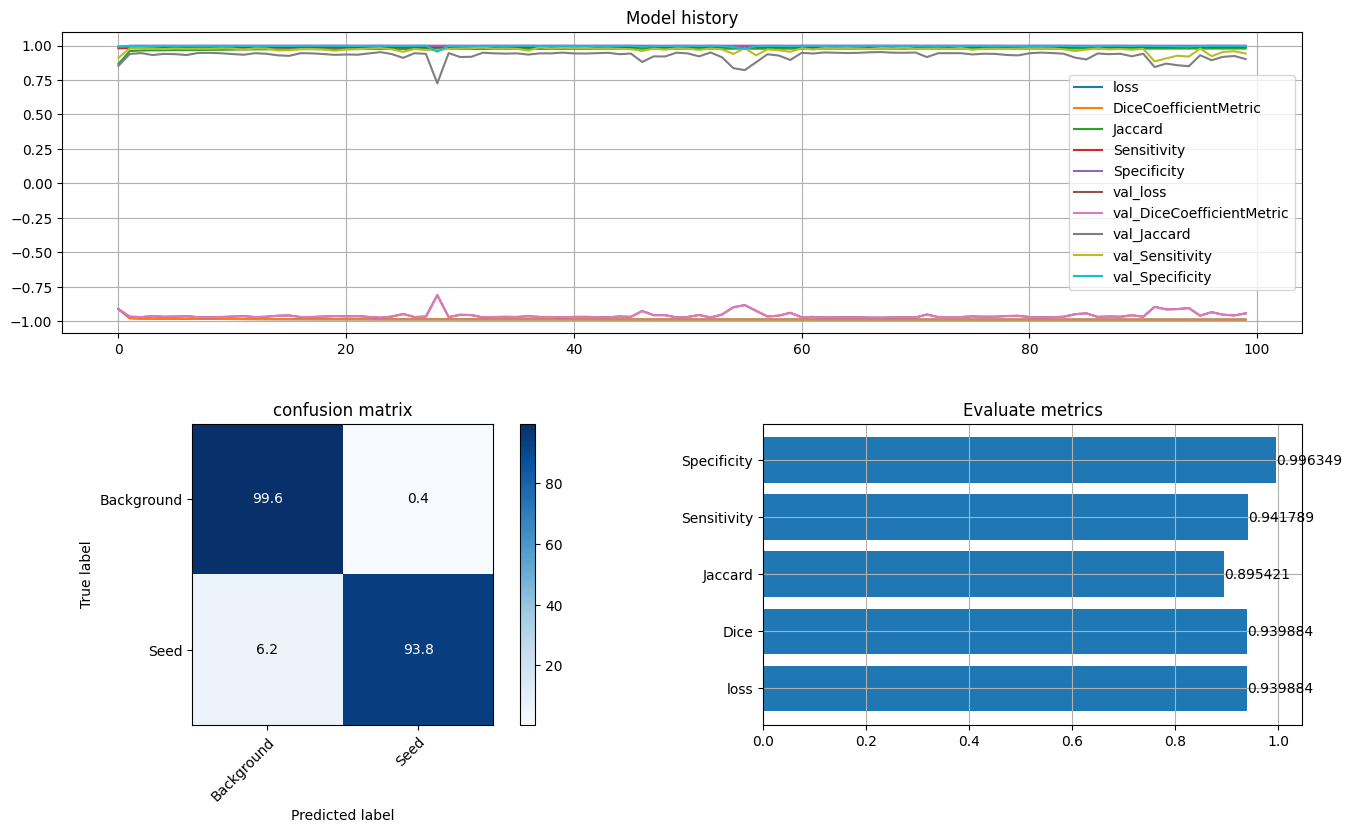

 Number of images for Partition 1: 2016
 Number of images for Partition 2: 864
 Number of images for Partition 3: 320


In [ ]:
for i in range(5):
  num = np.random.randint(0, 100)
  dataset = ZeaMaysSeeds(split=[0.1,0.3], seed = num)
  train,val,test = dataset()

  def preprocess(img,mask):
      img = tf.image.resize(img,(256,256))
      mask = tf.image.resize(mask,(256,256))#Ch 1: Seed, Ch 2: No germinate, Ch 3: germinate
      mask = tf.cast(mask>0, tf.float32)
      mask = mask[...,2][..., None]
      return img,mask

  train = train.map(lambda x,y,id:preprocess(x,y))
  train = train.batch(1)
  val = val.map(lambda x,y,id:preprocess(x,y))
  val = val.batch(1)
  test = test.map(lambda x,y,id:preprocess(x,y))
  test = test.batch(1)

  train = train.cache()
  val = val.cache()
  test = test.cache()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  model_history = model.fit(train,validation_data=val, epochs=100, verbose=0)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  fig = plt.figure(figsize=(16,9))

  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, :-1])
  ax3 = fig.add_subplot(gs[1:, -1])

  for i in model_history.history:
    ax1.plot(model_history.history[i],label=i)
  ax1.set_title('Model history')
  ax1.legend()
  ax1.grid()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  img_test = tf.zeros((0, 256, 256, 3), dtype=tf.float32)
  mask_test = tf.zeros((0, 256, 256,1), dtype=tf.float32)

  for img, mask in test:
      img_test = tf.concat([img_test, img], axis=0)
      mask_test = tf.concat([mask_test, mask], axis=0)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  mask_pred = model.predict(img_test)
  mask_pred = np.where(mask_pred > .5, 1, 0)
  evaluate_history = model.evaluate(img_test, mask_test)
  bars = ax3.barh(["loss","Dice","Jaccard","Sensitivity","Specificity"],np.abs(evaluate_history))
  ax3.bar_label(bars)
  ax3.set_title('Evaluate metrics')
  ax3.grid()

  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Then, convert the predicted and ground truth masks to single-dimensional arrays
  pred_flat = tf.reshape(mask_pred, [-1])
  true_flat = tf.reshape(mask_test, [-1])

  # Plot the confusion matrix
  utils.plot_confusion_matrix(true_flat, pred_flat, classes=['Background','Seed'], ax = ax2)
  ax2.set_title('confusion matrix')

  # Ajustar los espacios entre los subplots
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  # Mostrar la figura
  plt.show()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  del train, val, test, dataset
  tf.keras.backend.clear_session()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------